# HW3

The goals of this homework are:
1. Get acquainted with the transformers package and with the implemntation of BERT. 
2. Implement Adapters for transfer learning.
4. Get familiar with the GLUE benchmark.

## Problem with fine tuning the entire model

As we learned in the last lecture fine-tuning large pretrained models is the most effective transfer learning approch. However, in case we have a lot of downstream tasks the above method can be cumbersome since for each new task an entire new model needs to be trained.

## Adapters - Paramter Efficent approach
 In this exercise we will implement another method for transfer learning which only adds few trainable parameters per task, and new tasks can be added without revisiting previous ones. 
 
The method was proposed at the following paper https://arxiv.org/pdf/1902.00751.pdf and the details regarding the implmentation can be found in section 2.1 (you are also advised to look at section 3 for tuning the parameters)

**Please note that in addition to the adapter layers the autorhs also  trained a new layer normalization - For our excercise implementing this part is not mandatory!**





let's install requirements (we write it to file, for convenient if need to install outside from notebook)

In [ ]:
%%writefile requirements.txt
accelerate
datasets >= 1.1.3
sentencepiece != 0.1.92
protobuf
torch >= 1.3
git+https://github.com/huggingface/transformers

Writing requirements.txt


In [ ]:
%%capture
!pip install -r requirements.txt
!pip install wandb -qq

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%env WANDB_ENTITY=vova_ydata
%env WANDB_PROJECT=ydata_bert_adapter

env: WANDB_ENTITY=vova_ydata
env: WANDB_PROJECT=ydata_bert_adapter


In this excercise you are required to:
### 1. Implement adapter layer

fig. Architecture of the adapter module and its integration
with the Transformer. Left: We add the adapter module twice
to each Transformer layer: after the projection following multiheaded attention and after the two feed-forward layers. Right: The
adapter consists of a bottleneck which contains few parameters relative to the attention and feedforward layers in the original model.
The adapter also contains a skip-connection. During adapter tuning, the green layers are trained on the downstream data, this
includes the adapter, the layer normalization parameters, and the
final classification layer (not shown in the figure).

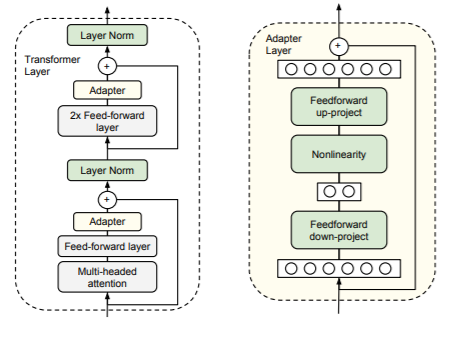

also we could check official tf implementation, according to https://github.com/google-research/adapter-bert/blob/master/modeling.py#L944 we could implement Adapter as module and then change output of the Bert encoders over iteration just like in official implementation.

```python
with tf.variable_scope("output"):
          attention_output = tf.layers.dense(
              attention_output,
              hidden_size,
              kernel_initializer=create_initializer(initializer_range))
          attention_output = dropout(attention_output, hidden_dropout_prob)
          if adapter_fn:
            attention_output = adapter_fn(attention_output)
          attention_output = layer_norm(attention_output + layer_input)
```

we use some parameters for adapter, that based on the article, e.g. init_range = 10^-2

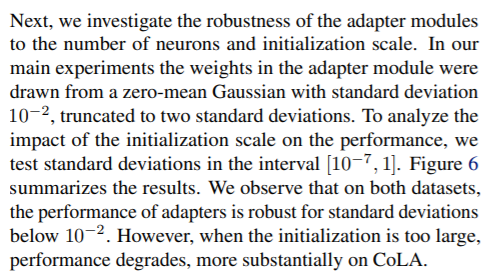

regarding adapter_size we chose =64, for simplicity in spite of that in article they used it like hyperparameter that has impact on task perfomance

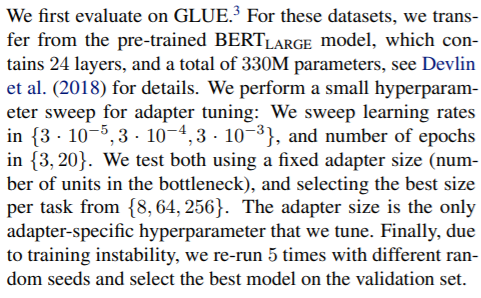

lr = 3*10^-5 (default one for glue benchmark)

In [ ]:
import transformers
from typing import NamedTuple, Union, Callable

import torch
from transformers.models.bert.modeling_bert import BertSelfOutput
from torch import nn
from torch.nn import functional as F

class AdapterConfig(NamedTuple):
    hidden_size: int
    adapter_size: int
    adapter_init_range: float


class BertAdapter(nn.Module):
    def __init__(self, config: AdapterConfig):
        super(BertAdapter, self).__init__()
        self.adapter_init_range = config.adapter_init_range
        self.hidden_size = config.hidden_size
        self.adapter_size = config.adapter_size
        
        self.down_project = nn.Linear(self.hidden_size, self.adapter_size)
        self.up_project = nn.Linear(self.adapter_size, self.hidden_size)
        self.activation = F.relu
        self.__init_weights__()

    def __init_weights__(self):
        
        nn.init.normal_(self.down_project.weight, std=self.adapter_init_range)
        nn.init.zeros_(self.down_project.bias)
        
        nn.init.normal_(self.up_project.weight, std=self.adapter_init_range)
        nn.init.zeros_(self.up_project.bias)

    def forward(self, hidden_states: torch.Tensor):
        down_projected = self.activation(self.down_project(hidden_states))
        up_projected = self.up_project(down_projected)
        return hidden_states + up_projected


class BertAdapterSelfOutput(nn.Module):
    def __init__(self,
                 self_output: BertSelfOutput,
                 config: AdapterConfig):
        super(BertAdapterSelfOutput, self).__init__()
        self.self_output = self_output
        self.adapter = BertAdapter(config)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor):
        """ 
        https://github.com/google-research/adapter-bert/blob/master/modeling.py#L939
        """
        hidden_states = self.self_output.dense(hidden_states)
        hidden_states = self.self_output.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states)
        hidden_states = self.self_output.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# just syntetic case on sentiment task inference
idx2cls = {0:"negative", 1:"positive"}
cls2idx = {"negative":0, "positive":1}

model_name_or_path = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path, 
    num_labels=len(cls2idx)
)

model.config.id2label = idx2cls
model.config.label2id = cls2idx

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
config = AdapterConfig(
    hidden_size=model.bert.config.hidden_size,
    adapter_size=64,
    adapter_init_range=1e-2
)

# adding bert adapters like in official implementation
# https://github.com/google-research/adapter-bert/blob/master/modeling.py#L944
for layer in model.bert.encoder.layer:
    layer.attention.output = BertAdapterSelfOutput(self_output=layer.attention.output, config=config)
    layer.output = BertAdapterSelfOutput(self_output=layer.output, config=config)

# freezing bert accoding to article (we'll unfreeze adapter layers later)
for param in model.bert.parameters():
    param.requires_grad = False

# unfreezing adapters, layer normalization and classifier layer
for name, submodule in model.bert.named_modules():
    if isinstance(submodule, (BertAdapter, nn.LayerNorm)):
        for param_name, param in submodule.named_parameters():
            param.requires_grad = True

model.classifier.requires_grad = True

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertAdapterSelfOutput(
              (self_output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
output = model(**tokenizer(["This film is good"], return_tensors="pt"))
idx2cls[output.logits.argmax(dim=1).item()]

'positive'

we do it without fine-tuning and that's ok to get some random answer btw

let's check, does pipeline is working after adding adapter?

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [ ]:
pipe("This film is good")

[{'label': 'positive', 'score': 0.5238363742828369}]


### 2. Modify the Implementation of BERT to include the adapter layer 

(clone the transformers package and use the exisiting BERT implemntation which can be found in the following path ./src/transformers/models/bert/modeling_bert.py ) 

we decided to use run_glue.py (https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py) script and add to there option of using adapter when adapt layers would be added

In [ ]:
!wget https://gist.githubusercontent.com/imvladikon/604abca1a00196230db24efba23774ee/raw/56989783955c57921baf6bf1567b618e9c0d81d0/run_glue.py -O run_glue.py 

--2021-05-29 14:41:17--  https://gist.githubusercontent.com/imvladikon/604abca1a00196230db24efba23774ee/raw/56989783955c57921baf6bf1567b618e9c0d81d0/run_glue.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27342 (27K) [text/plain]
Saving to: ‘run_glue.py’

run_glue.py         100%[===================>]  26.70K  --.-KB/s    in 0.001s  

2021-05-29 14:41:18 (37.3 MB/s) - ‘run_glue.py’ saved [27342/27342]



we added these lines:

In [ ]:
!sed -n '70,122p;123q' run_glue.py

##################### Adapter #############################################

class AdapterConfig(NamedTuple):
    hidden_size: int
    adapter_size: int
    adapter_init_range: float


class BertAdapter(nn.Module):
    def __init__(self, config: AdapterConfig):
        super(BertAdapter, self).__init__()
        self.adapter_init_range = config.adapter_init_range
        self.hidden_size = config.hidden_size
        self.adapter_size = config.adapter_size
        
        self.down_project = nn.Linear(self.hidden_size, self.adapter_size)
        self.up_project = nn.Linear(self.adapter_size, self.hidden_size)
        self.activation = F.relu
        self.__init_weights__()

    def __init_weights__(self):
        
        nn.init.normal_(self.down_project.weight, std=self.adapter_init_range)
        nn.init.zeros_(self.down_project.bias)
        
        nn.init.normal_(self.up_project.weight, std=self.adapter_init_range)
        nn.init.zeros_(self.up_project.bias)

    def forward(se

In [ ]:
!sed -n '242,248p;249q' run_glue.py

    use_adapter: bool = field(
        default=False,
        metadata={"help": "Whether to use adapter or not"},
    )
    adapter_size: int = field(
        default=64,
        metadata={"help": "adapter_size"},


In [ ]:
!sed -n '384,407p;408q' run_glue.py

    if isinstance(model_args.use_adapter, bool) and model_args.use_adapter:
        config = AdapterConfig(
            hidden_size=model.bert.config.hidden_size,
            adapter_size=model_args.adapter_size,
            adapter_init_range=1e-2
        )
        # adding bert adapters like in official impl.
        # https://github.com/google-research/adapter-bert/blob/master/modeling.py#L944
        for layer in model.bert.encoder.layer:
            layer.attention.output = BertAdapterSelfOutput(self_output=layer.attention.output, config=config)
            layer.output = BertAdapterSelfOutput(self_output=layer.output, config=config)
            
        # freezing bert accoding to article (and after we'll unfreeze adapters, because we freezed all bert layers)
        for param in model.bert.parameters():
            param.requires_grad = False
            
        # unfreezing adapters, and classifier layer
        for name, sub_module in model.bert.named_modules():
            i

### 3. Finetune BERT on the GLUE benchmark with and without Adapters and report the results 

(see https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb  for reference on using the GLUE benchmark)  

#### Runnning modified run_glue.py script

we modified already prepared huggingface script https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py but we added also option of the adding Adapter to Bert model . Using diff between files, is easier understand what we changed. we used to dev transformers version

it's our version of run_glue.py

In [ ]:
!wget https://gist.githubusercontent.com/imvladikon/604abca1a00196230db24efba23774ee/raw/56989783955c57921baf6bf1567b618e9c0d81d0/run_glue.py -O run_glue.py 

--2021-05-29 14:41:07--  https://gist.githubusercontent.com/imvladikon/604abca1a00196230db24efba23774ee/raw/56989783955c57921baf6bf1567b618e9c0d81d0/run_glue.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27342 (27K) [text/plain]
Saving to: ‘run_glue.py’

run_glue.py         100%[===================>]  26.70K  --.-KB/s    in 0.001s  

2021-05-29 14:41:08 (47.4 MB/s) - ‘run_glue.py’ saved [27342/27342]



In [ ]:
GLUE_TASKS = ["cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

Run GLUE on BERT without adapter and log the results

In [ ]:
!mkdir -p ./logs
!mkdir -p ./artefacts

In [ ]:
for task in GLUE_TASKS:
    !python3 run_glue.py --model_name_or_path bert-base-uncased --load_best_model_at_end --save_total_limit 2 --task_name {task} --do_train --do_eval --max_seq_length 128 --per_device_train_batch_size 32 --learning_rate 2e-5 --num_train_epochs 3 --logging_dir ./logs/{task} --output_dir ./artefacts/{task}/ >> ./logs/{task}.log

2021-05-29 08:51:18.711399: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Downloading: 28.8kB [00:00, 17.1MB/s]       
Downloading: 28.7kB [00:00, 17.4MB/s]       
Downloading: 100% 377k/377k [00:00<00:00, 569kB/s] 
[INFO|file_utils.py:1556] 2021-05-29 08:51:24,700 >> https://huggingface.co/bert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpx6atl7iv
Downloading: 100% 570/570 [00:00<00:00, 363kB/s]
[INFO|file_utils.py:1560] 2021-05-29 08:51:25,050 >> storing https://huggingface.co/bert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
[INFO|file_utils.py:1568] 2021-05-29 08:51:25,050 >> creating metadata file for /root/.cache/huggingface/transformers/3c61

Run GLUE on BERT with adapter and log the results

In [ ]:
!mkdir -p ./logs_adapter
!mkdir -p ./artefacts_adapter

In [ ]:
for task in GLUE_TASKS:
    !python3 run_glue.py --model_name_or_path bert-base-uncased --task_name {task} --do_train --do_eval --load_best_model_at_end --save_total_limit 2 --max_seq_length 128 --per_device_train_batch_size 32 --learning_rate 2e-5 --num_train_epochs 3 --use_adapter --logging_dir ./logs_adapter/{task} --output_dir ./artefacts_adapter/{task}/ >> ./logs_adapter/{task}.log

2021-05-29 14:41:33.171454: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[INFO|configuration_utils.py:517] 2021-05-29 14:41:36,057 >> loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
[INFO|configuration_utils.py:553] 2021-05-29 14:41:36,058 >> Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_e

btw we could parse eval results by hand using code below or just check logs and output at wandb

In [ ]:
import json
import os
import pandas as pd

In [ ]:
for task in GLUE_TASKS:
  data = []

  eval_file = f"./artefacts/{task}/eval_results.json"
  data.append({"task":task, "adapter":0, **json.load(open(eval_file))})

  eval_file = f"./artefacts_adapter/{task}/eval_results.json"
  data.append({"task":task, "adapter":1, **json.load(open(eval_file))})

  eval_metrics = pd.DataFrame(data)
  display(eval_metrics)

,task,adapter,epoch,eval_loss,eval_matthews_correlation,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second
0,cola,0,3.0,0.522538,0.585483,2.9237,1043,356.742,44.807
1,cola,1,3.0,0.558666,0.184947,3.0588,1043,340.984,42.827


,task,adapter,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second
0,mnli,0,3.0,0.846827,0.472598,26.8630,9832,366.005,45.751
1,mnli,1,3.0,0.793023,0.521226,27.9378,9832,351.924,43.991


,task,adapter,epoch,eval_accuracy,eval_combined_score,eval_f1,eval_loss,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second
0,mrpc,0,3.0,0.845588,0.870030,0.894472,0.427325,1.1429,408,357.002,44.625
1,mrpc,1,3.0,0.683824,0.748025,0.812227,0.603371,1.1982,408,340.512,42.564


,task,adapter,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second
0,qnli,0,3.0,0.914882,0.314756,14.8790,5463,367.163,45.904
1,qnli,1,3.0,0.871316,0.295931,15.8245,5463,345.225,43.161


,task,adapter,epoch,eval_accuracy,eval_combined_score,eval_f1,eval_loss,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second
0,qqp,0,3.0,0.909300,0.893657,0.878015,0.285632,108.0118,40430,374.311,46.791
1,qqp,1,3.0,0.856443,0.835161,0.813879,0.316410,116.3385,40430,347.520,43.442


,task,adapter,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second
0,rte,0,3.0,0.628159,0.671649,0.7595,277,364.726,46.084
1,rte,1,3.0,0.534296,0.691911,0.8127,277,340.844,43.067


,task,adapter,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second
0,sst2,0,3.0,0.930046,0.288950,2.3967,872,363.840,45.480
1,sst2,1,3.0,0.903670,0.242362,2.5530,872,341.557,42.695


,task,adapter,epoch,eval_combined_score,eval_loss,eval_pearson,eval_runtime,eval_samples,eval_samples_per_second,eval_spearmanr,eval_steps_per_second
0,stsb,0,3.0,0.885276,0.518227,0.886775,4.0706,1500,368.493,0.883776,46.184
1,stsb,1,3.0,0.801415,0.851750,0.793359,4.7059,1500,318.751,0.809472,39.950


,task,adapter,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples,eval_samples_per_second,eval_steps_per_second
0,wnli,0,3.0,0.352113,0.707678,0.2094,71,339.076,42.981
1,wnli,1,3.0,0.478873,0.694306,0.2127,71,333.754,42.307


we saved logs and perfomance output with weights in the https://drive.google.com/drive/folders/1xx8b6c6duuQb4OGXOUPtGJEdKZ1CKUzO?usp=sharing , and the main wandb link for artefacts and logs is https://wandb.ai/vova_ydata/ydata_bert_adapter where is possible to check difference between models perfomance. 

**WNLI task: BERT with Adapters performance is significantly better**

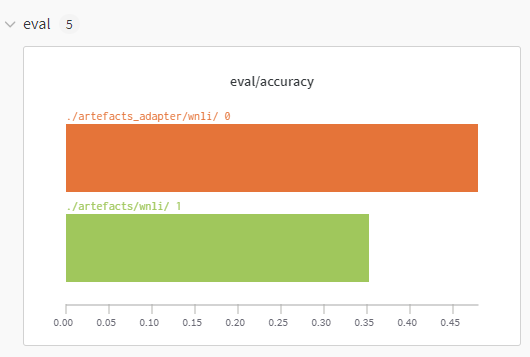

**SST-2 Task: BERT with Adapters performance is a bit worse**

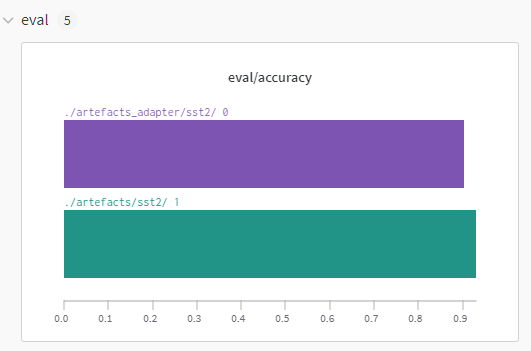

As we see, for some tasks adapter with default parameters provides better results that fine-tuned BERT (for example WNLI), for some other tasks, the performance is close to BERT (that's what the article suggests), and there are tasks where performance of Adapters is worse (like COLA). 

To adress that, the article suggests to tune the init_size hyperparameter, as each task performs best with a different value of that hyperparameter.

As expected, training with adapters tool less time (~24% time saving) as we had significantly less parameters tune and most of BERT parameters were frozen.